In [2]:
import pandas as pd, os, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%run run_method_comparison.py

In [3]:
folder_path = '../supplementary/'

In [4]:
res_names = ['likelihood_only', 'lengthscales', 'optimize_all']

In [5]:
results = []
for name in res_names:
    results.append(pd.read_csv(os.path.join(folder_path, 'trajectory_{}/time_rvalue.csv'.format(name)), index_col=[0,1,2]))

In [6]:
wanderlust = pd.read_csv(os.path.join(folder_path, 'simulations', 'wanderlust.csv'), index_col=[0,1,2])
wanderlust.index = wanderlust.index.set_names(['latent space', 'method', 'data simulation'])
wanderlust.index = wanderlust.index.set_levels(['SLS{}'.format(level) for level in wanderlust.index.levels[0]], level=0, inplace=False)
wanderlust.sort_index(inplace=True)

In [7]:
tmp = pd.concat(results, keys=res_names).copy().sort_index().stack(dropna=False)

tmp.name = 'rvalue'
tmp.index.levels[4].name = 'time correction'
tmp.index.levels[0].name = 'manifold learning'

test = tmp.reset_index()
idx = pd.IndexSlice

test = test.set_index(['latent space', 'time correction', 'method', 'manifold learning', 'data simulation']).sort_index()

In [8]:
order = ["SLS{}".format(int(lvl)) for lvl in seeds]

In [9]:
meth_idx = [u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']

others = test.loc[idx[:, :, meth_idx, 'lengthscales', :], :]
others.index = others.index.droplevel(['manifold learning'])

manifold = test.loc[idx[:, :, 'cellSLAM', :, :], :]
manifold.index = manifold.index.droplevel(['method'])

names = list(manifold.index.names)
names[2] = 'method'
manifold.index.names = names
manifold.index = manifold.index.set_levels([u'cellSLAM Weighted', u'cellSLAM Mixed', u'cellSLAM'], level=2)

data = pd.concat((others,manifold)).abs().sort_index()
data.index = data.index.set_levels(["SLS{}".format(int(lvl)) for lvl in manifold.index.levels[0]], level=0)

In [10]:
dat = data.loc[idx[:, 'Tree Corrected', ['ICA', 'cellSLAM']], :]
dat.index = dat.index.droplevel('time correction')

dat = pd.concat([dat, wanderlust.loc[idx[:, 'Wanderlust'], ['rvalue']]])


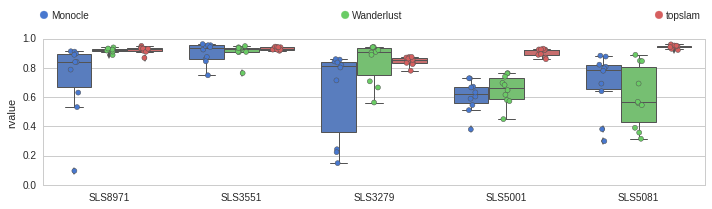

In [16]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(10,3))
gs = plt.GridSpec(6,1)
ax = fig.add_subplot(gs[1:,:])

### Compare all:
# meth_idx = [ u'cellSLAM Mixed', u'cellSLAM Weighted', u'cellSLAM', 
#             u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']

# cols = sns.color_palette('muted', 6)
# _tmp = sns.color_palette('YlGnBu_d', 3)#sns.dark_palette(cols[0], 8, reverse=True)[:3]
# cols = cols[1:]
# cols = _tmp + cols

### Compare only to full cellSLAM:

meth_idx = [ 'Monocle','Wanderlust',u'topslam']

dat = data.loc[idx[:, 'Tree Corrected', ['ICA', 'cellSLAM']], :]
dat.index = dat.index.droplevel('time correction')

dat = pd.concat([dat, wanderlust.loc[idx[:, 'Wanderlust'], ['rvalue']]])
dat.index = dat.index.set_levels([name if not (name=='ICA') else 'Monocle' for name in dat.index.levels[1]], level=1)
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[1]], level=1)

dat = dat.reset_index()

cols = sns.color_palette('muted', 3)
#_tmp = sns.color_palette('YlGnBu_d', 3)#sns.dark_palette(cols[0], 8, reverse=True)[:3]
#cols = cols[1:]
#cols = _tmp + cols


bp = sns.boxplot(data=dat, 
               x='latent space', 
               y='rvalue', ax=ax, 
               hue='method', hue_order=meth_idx,
                 order=order,
               palette=cols,
               #whis=60,
               linewidth=1,
                 notch=False,
               #color=".3"
           )

sp = sns.stripplot(data=dat, 
              x='latent space', 
              y='rvalue', ax=ax, 
              hue='method', hue_order=meth_idx,
                 order=order,
              palette=cols,
              split=True,
              jitter=1,
              linewidth=.5,
             )

_ = ax.set_ylim(.0, 1.)
yloc = plt.MaxNLocator(5)
ax.yaxis.set_major_locator(yloc)
_h, _l = ax.get_legend_handles_labels()
ax.legend([],[])
ax.set_xlabel('')

ax = fig.add_subplot(gs[0,:])
from matplotlib.legend_handler import HandlerLine2D

ncol = len(meth_idx)
ax.legend(_h[-ncol:], _l[-ncol:], 
          bbox_to_anchor=(-.02, 0, 1.02, 1.), 
          mode='expand', 
          ncol=ncol, 
          borderaxespad=0,
          handletextpad=-.3,
          scatteryoffsets=[.5],
         )
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig.savefig('../diagrams/simulation/rvalue_comparison_methods.pdf')

In [43]:
dat = data.loc[idx[:, 'Tree Corrected', ['ICA', 'cellSLAM']], :]
dat.index = dat.index.droplevel('time correction')

dat = pd.concat([dat, wanderlust.loc[idx[:, 'Wanderlust'], ['rvalue']]])
dat.index = dat.index.set_levels([name if not (name=='ICA') else 'Monocle' for name in dat.index.levels[1]], level=1)
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[1]], level=1)

dat.sort_index(inplace=True)

print("Overall performance:", dat.groupby(level='method').aggregate(['mean', 'std']))

('Overall performance:',               rvalue          
                mean       std
method                        
Monocle     0.715058  0.224702
Wanderlust  0.784626  0.179717
topslam     0.910656  0.040398)


In [44]:
### Compare only to full cellSLAM:


meth_idx = [ 'Monocle','Wanderlust',u'cellSLAM']

dat = data.loc[idx[:, 'Tree Corrected', ['ICA', 'cellSLAM']], :]
dat.index = dat.index.droplevel('time correction')

dat = pd.concat([dat, wanderlust.loc[idx[:, 'Wanderlust'], ['rvalue']]])
dat.index = dat.index.set_levels([name if not (name=='ICA') else 'Monocle' for name in dat.index.levels[1]], level=1)
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[1]], level=1)

meth_idx = [ 'Monocle','Wanderlust',u'topslam']

dat.sort_index(inplace=True)

g = dat.groupby(level=['method', 'latent space'])

agg = g.aggregate(('mean', 'std'))

dat.to_csv('../supplementary/method_comparison_all.csv', )

agg.columns = agg.columns.droplevel(0)
agg = agg.sort_values(by='mean')
agg.columns = (['$\\rho$', '$\\pm$'])
agg = agg.unstack(level=1).swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
agg.columns.names = [None, None]
agg.index.name = None
agg = agg[order]
agg = agg.loc[meth_idx]

agg.columns = ['\\multicolumn{{2}}{{c}}{{ {} }}'.format(_c[0]) if _c[1] == '$\\rho$' else '' for _c in agg.columns]

ma = agg.round(2).max()

def fc(column):
    def g(x):
        if x == ma[column]:
            return '\\mathbf{{ {:.2f} }}'.format(x)
        else:
            return '{:.2f}'.format(x)
    return g

with open('../supplementary/method_comparison.tex', 'w') as f:
    s = agg.round(2).to_latex(escape=False, 
                      column_format='l*{'+str(len(agg.columns))+'}{>{$}r<{$}@{$\pm$}>{$}l<{$}}', 
                      header=True, formatters=dict([(_o, fc(_o)) for _o in agg.columns if _o != '']))
    f.write(s.replace('&       &', '&').replace('&       \\\\','\\\\'))
agg.T.to_latex('../supplementary/method_comparison_wide.tex', escape=False)

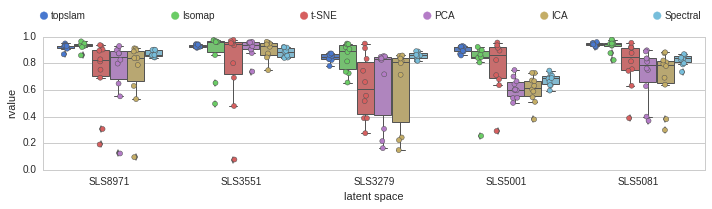

In [25]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(10,3))
gs = plt.GridSpec(6,1)
ax = fig.add_subplot(gs[1:,:])

### Compare all:
# meth_idx = [ u'cellSLAM Mixed', u'cellSLAM Weighted', u'cellSLAM', 
#             u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']

# cols = sns.color_palette('muted', 6)
# _tmp = sns.color_palette('YlGnBu_d', 3)#sns.dark_palette(cols[0], 8, reverse=True)[:3]
# cols = cols[1:]
# cols = _tmp + cols

### Compare only to full cellSLAM:

cols = sns.color_palette('muted', 6)
#_tmp = sns.color_palette('YlGnBu_d', 3)#sns.dark_palette(cols[0], 8, reverse=True)[:3]
#cols = cols[1:]
#cols = _tmp + cols

meth_idx = [ u'topslam', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']
dat = data.loc[idx[:, 'Tree Corrected'], :]
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[2]], level=2)
dat = dat.reset_index()


bp = sns.boxplot(data=dat, 
               x='latent space', 
               y='rvalue', ax=ax, 
               hue='method', hue_order=meth_idx,
                 order=order,
               palette=cols,
               #whis=60,
               linewidth=1,
                 notch=False,
               #color=".3"
           )

sp = sns.stripplot(data=dat, 
              x='latent space', 
              y='rvalue', ax=ax, 
              hue='method', hue_order=meth_idx,
                 order=order,
              palette=cols,
              split=True,
              jitter=1,
              linewidth=.5,
             )

_ = ax.set_ylim(.0, 1.)
yloc = plt.MaxNLocator(5)
ax.yaxis.set_major_locator(yloc)
_h, _l = ax.get_legend_handles_labels()
ax.legend([],[])

ax = fig.add_subplot(gs[0,:])
from matplotlib.legend_handler import HandlerLine2D

ncol = len(meth_idx)
ax.legend(_h[-ncol:], _l[-ncol:], 
          bbox_to_anchor=(-.02, 0, 1.02, 1.), 
          mode='expand', 
          ncol=ncol, 
          borderaxespad=0,
          handletextpad=-.3,
          scatteryoffsets=[.5],
         )
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig.savefig('../diagrams/simulation/tree_errors.pdf')

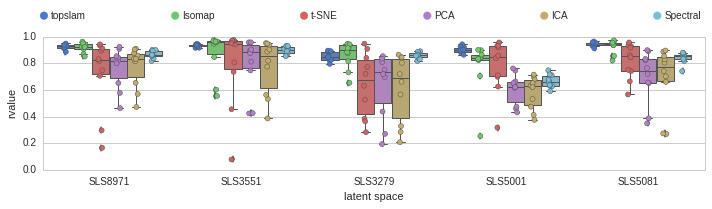

In [42]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(10,3))
gs = plt.GridSpec(6,1)
ax = fig.add_subplot(gs[1:,:])

cols = sns.color_palette('muted', 6)
#_tmp = sns.color_palette('YlGnBu_d', 3)#sns.dark_palette(cols[0], 8, reverse=True)[:3]
#cols = cols[1:]
#cols = _tmp + cols

meth_idx = [ u'topslam', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']
dat = data.loc[idx[:, '3N Corrected'], :]
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[2]], level=2)
dat = dat.reset_index()


bp = sns.boxplot(data=dat, 
               x='latent space', 
               y='rvalue', ax=ax, 
               hue='method', hue_order=meth_idx,
                 order=order,
               palette=cols,
               #whis=60,
               linewidth=1,
                 notch=False,
               #color=".3"
           )

sp = sns.stripplot(data=dat, 
              x='latent space', 
              y='rvalue', ax=ax, 
              hue='method', hue_order=meth_idx,
                 order=order,
              palette=cols,
              split=True,
              jitter=1,
              linewidth=.5,
             )

_ = ax.set_ylim(.0, 1.)
yloc = plt.MaxNLocator(5)
ax.yaxis.set_major_locator(yloc)
_h, _l = ax.get_legend_handles_labels()
ax.legend([],[])

ax = fig.add_subplot(gs[0,:])
from matplotlib.legend_handler import HandlerLine2D

ncol = len(meth_idx)
ax.legend(_h[-ncol:], _l[-ncol:], 
          bbox_to_anchor=(-.02, 0, 1.02, 1.), 
          mode='expand', 
          ncol=ncol, 
          borderaxespad=0,
          handletextpad=-.3,
          scatteryoffsets=[.5],
         )
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig.savefig('../diagrams/simulation/3nn_errors.pdf')

In [35]:
### Compare only to full cellSLAM:


meth_idx = [ u'cellSLAM', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']
dat = data.loc[idx[:, 'Tree Corrected', meth_idx], :]
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[2]], level=2)
#dat = dat.reset_index()

meth_idx = [ u'topslam', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']

g = dat.groupby(level=['method', 'latent space'])

agg = g.aggregate(('mean', 'std'))

agg.to_csv('../supplementary/simulations/tree_errors.csv', )

agg.columns = agg.columns.droplevel(0)
agg = agg.sort_values(by='mean')
agg.columns = (['$\\rho$', '$\\pm$'])
agg = agg.unstack(level=1).swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
agg.columns.names = [None, None]
agg.index.name = None
agg = agg[order]
agg = agg.loc[meth_idx]

agg.columns = ['\\multicolumn{{2}}{{c}}{{ {} }}'.format(_c[0]) if _c[1] == '$\\rho$' else '' for _c in agg.columns]

ma = agg.round(2).max()

def fc(column):
    def g(x):
        if x == ma[column]:
            return '\\mathbf{{ {:.2f} }}'.format(x)
        else:
            return '{:.2f}'.format(x)
    return g

with open('../supplementary/simulations/tree_errors.tex', 'w') as f:
    s = agg.round(2).to_latex(escape=False, 
                      column_format='l*{'+str(len(agg.columns))+'}{>{$}r<{$}@{$\pm$}>{$}l<{$}}', 
                      header=True, formatters=dict([(_o, fc(_o)) for _o in agg.columns if _o != '']))
    f.write(s.replace('&       &', '&').replace('&       \\\\','\\\\'))
#agg.T.to_latex('../supplementary/tree_errors_wide.tex', escape=False)

In [32]:
agg.round(2)

\multicolumn{2}{c}{ SLS8971 }        \multicolumn{2}{c}{ SLS3551 }  \
topslam                            0.92  0.02                           0.93   
Isomap                             0.93  0.03                           0.88   
t-SNE                              0.73  0.26                           0.78   
PCA                                0.74  0.25                           0.91   
ICA                                0.73  0.26                           0.90   
Spectral                           0.87  0.02                           0.88   

                \multicolumn{2}{c}{ SLS3279 }        \
topslam   0.01                           0.85  0.03   
Isomap    0.17                           0.85  0.11   
t-SNE     0.30                           0.62  0.24   
PCA       0.07                           0.65  0.29   
ICA       0.07                           0.63  0.30   
Spectral  0.03                           0.86  0.03   

          \multicolumn{2}{c}{ SLS5001 }        \multicolumn{2}{c}{ SLS5081 }  \
topslam                            0.91  0.03                           0.94   
Isomap                             0.80  0.20                           0.93   
t-SNE                              0.78  0.21                           0.79   
PCA                                0.61  0.08                           0.72   
ICA                                0.61  0.11                           0.70   
Spectral                           0.68  0.05                           0.83   

                
topslam   0.01  
Isomap    0.05  
t-SNE     0.18  
PCA       0.19  
ICA       0.20  
Spectral  0.04

In [40]:
### Compare only to full cellSLAM:


meth_idx = [ u'cellSLAM', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']
dat = data.loc[idx[:, '5N Corrected', meth_idx], :]
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[2]], level=2)
#dat = dat.reset_index()

meth_idx = [ u'topslam', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']

g = dat.groupby(level=['method', 'latent space'])

agg = g.aggregate(('mean', 'std'))

agg.to_csv('../supplementary/simulations/5nn_errors.csv', )

agg.columns = agg.columns.droplevel(0)
agg = agg.sort_values(by='mean')
agg.columns = (['$\\rho$', '$\\pm$'])
agg = agg.unstack(level=1).swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
agg.columns.names = [None, None]
agg.index.name = None
agg = agg[order]
agg = agg.loc[meth_idx]

agg.columns = ['\\multicolumn{{2}}{{c}}{{ {} }}'.format(_c[0]) if _c[1] == '$\\rho$' else '' for _c in agg.columns]

ma = agg.round(2).max()

def fc(column):
    def g(x):
        if x == ma[column]:
            return '\\mathbf{{ {:.2f} }}'.format(x)
        else:
            return '{:.2f}'.format(x)
    return g

with open('../supplementary/simulations/5nn_errors.tex', 'w') as f:
    s = agg.round(2).to_latex(escape=False, 
                      column_format='l*{'+str(len(agg.columns))+'}{>{$}r<{$}@{$\pm$}>{$}l<{$}}', 
                      header=True, formatters=dict([(_o, fc(_o)) for _o in agg.columns if _o != '']))
    f.write(s.replace('&       &', '&').replace('&       \\\\','\\\\'))
#agg.T.to_latex('../supplementary/tree_errors_wide.tex', escape=False)

In [41]:
### Compare only to full cellSLAM:


meth_idx = [ u'cellSLAM', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']
dat = data.loc[idx[:, '3N Corrected', meth_idx], :]
dat.index = dat.index.set_levels([name if not (name=='cellSLAM') else 'topslam' for name in dat.index.levels[2]], level=2)
#dat = dat.reset_index()

meth_idx = [ u'topslam', u'Isomap', u't-SNE', u'PCA', u'ICA', u'Spectral']

g = dat.groupby(level=['method', 'latent space'])

agg = g.aggregate(('mean', 'std'))

agg.to_csv('../supplementary/simulations/3nn_errors.csv', )

agg.columns = agg.columns.droplevel(0)
agg = agg.sort_values(by='mean')
agg.columns = (['$\\rho$', '$\\pm$'])
agg = agg.unstack(level=1).swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
agg.columns.names = [None, None]
agg.index.name = None
agg = agg[order]
agg = agg.loc[meth_idx]

agg.columns = ['\\multicolumn{{2}}{{c}}{{ {} }}'.format(_c[0]) if _c[1] == '$\\rho$' else '' for _c in agg.columns]

ma = agg.round(2).max()

def fc(column):
    def g(x):
        if x == ma[column]:
            return '\\mathbf{{ {:.2f} }}'.format(x)
        else:
            return '{:.2f}'.format(x)
    return g

with open('../supplementary/simulations/3nn_errors.tex', 'w') as f:
    s = agg.round(2).to_latex(escape=False, 
                      column_format='l*{'+str(len(agg.columns))+'}{>{$}r<{$}@{$\pm$}>{$}l<{$}}', 
                      header=True, formatters=dict([(_o, fc(_o)) for _o in agg.columns if _o != '']))
    f.write(s.replace('&       &', '&').replace('&       \\\\','\\\\'))
#agg.T.to_latex('../supplementary/tree_errors_wide.tex', escape=False)

In [18]:
runtimes = []
for name in res_names:
    runtimes.append(pd.read_csv(os.path.join(folder_path, 'trajectory_{}/runtimes.csv'.format(name)), index_col=[0,1,2]))

In [19]:
runtimes = pd.concat(runtimes, keys=res_names).reset_index()
runtimes.columns = ['method', 'SLS', 'repeat', 'runtime [s]']

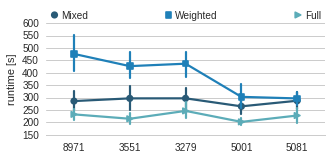

In [20]:
# We compare all the runtimes of different learning techniques, full is topslam!

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,2))

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.factorplot(x="SLS", y="runtime [s]", hue="method", data=runtimes, order=seeds,
                   palette='YlGnBu_d', ax=ax, facet_kws=dict(), 
                   kind='point', scale=.7, markers=list('os>'), 
                  )
g.fig.clf()

_h, _l = ax.get_legend_handles_labels()
ax.legend(_h, ['Mixed', 'Weighted', 'Full'], 
          bbox_to_anchor=(-.02, 0, 1.02, 1.15), 
          mode='expand', 
          loc='upper left',
          ncol=3, 
          borderaxespad=0,
          handletextpad=-.3,
          scatteryoffsets=[.5],
         )

ax.set_ylabel('runtime [s]')
ax.set_xlabel('')
sns.despine(fig, left=True)
fig.savefig('../diagrams/simulation/runtimes.pdf', transparent=True, bbox='tight')